In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from os import listdir
from scipy.stats import linregress
from matplotlib import pyplot as plt
from uncertainties import ufloat

plt.style.use('seaborn-v0_8')

In [2]:

with open('dump.Au_4_573') as f:
    lines = f.readlines()
    data = np.array([[float(y) for y in x.split()[2:]] for x in lines[9::10]])
    time = np.array([int(x) for x in lines[1::10]]).reshape(-1, 1)

df = pd.DataFrame(np.hstack([time, data]), columns=['step', 'x', 'y', 'z', 'vx', 'vy', 'vz'])
df.head()

,step,x,y,z,vx,vy,vz
0,25000.0,19.7645,-0.124004,20.6158,-0.876578,-0.674494,-1.53892
1,25010.0,19.7567,-0.131073,20.5992,-0.673791,-0.745765,-1.76372
2,25020.0,19.7512,-0.139059,20.5811,-0.418734,-0.859210,-1.83875
3,25030.0,19.7484,-0.148408,20.5629,-0.152302,-1.017880,-1.78277
4,25040.0,19.7480,-0.159527,20.5457,0.065192,-1.209080,-1.63605


In [3]:
df[['x', 'y', 'z']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500001 entries, 0 to 500000
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       500001 non-null  float64
 1   y       500001 non-null  float64
 2   z       500001 non-null  float64
dtypes: float64(3)
memory usage: 11.4 MB


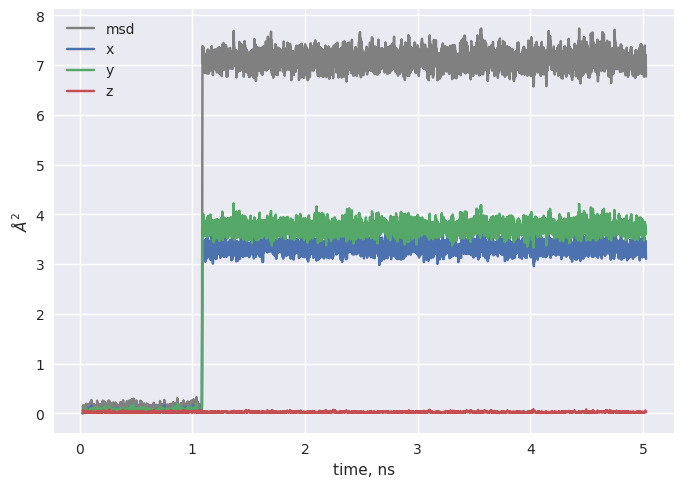

In [4]:
sd = (df[['x', 'y', 'z']] - df[['x', 'y', 'z']].iloc[0]) ** 2

window_size = 500  # Размер окна для скользящего среднего
sd_smoothed = sd.rolling(window=window_size).mean()

plt.plot(df['step'] / 1e6, sd_smoothed.sum(axis=1), label='msd', c='gray')
plt.plot(df['step'] / 1e6, sd_smoothed['x'], label='x')
plt.plot(df['step'] / 1e6, sd_smoothed['y'], label='y')
plt.plot(df['step'] / 1e6, sd_smoothed['z'], label='z')

plt.ylabel('$\\AA^2$')
plt.xlabel('time, ns')

plt.legend()
plt.show()

In [8]:
S = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
T_array = [523, 573, 623, 673, 723]

T_array = np.sort(np.unique([int(x.replace('.out', '').split('_')[-1]) for x in listdir() if '.out' in x and 'gold' in x]))
T_array

array([523, 548, 573, 623, 673, 723])

In [9]:


datas = []
for s in tqdm(S):
    T_datas = []
    for T in T_array:
        file = f'dump.Au_{s}_{T}'
        
        with open(file) as f:
            lines = f.readlines()
            data = np.array([[float(y) for y in x.split()[2:]] for x in lines[9::10]])
            time = np.array([int(x) for x in lines[1::10]]).reshape(-1, 1)

        df = pd.DataFrame(np.hstack([time, data]), columns=['step', 'x', 'y', 'z', 'vx', 'vy', 'vz'])
        sd = (df[['x', 'y', 'z']] - df[['x', 'y', 'z']].iloc[0]) ** 2
        sd['step'] = df['step']
        
        T_datas.append(sd)
    datas.append(T_datas)


        

100%|███████████████████████████████████████████| 10/10 [03:21<00:00, 20.19s/it]


In [51]:
sd.head()

,x,y,z,step
0,0.000000,0.000000,0.000000,25000.0
1,0.000213,0.000294,0.000137,25010.0
2,0.000807,0.000963,0.000467,25020.0
3,0.001742,0.001805,0.000835,25030.0
4,0.003002,0.002722,0.001063,25040.0


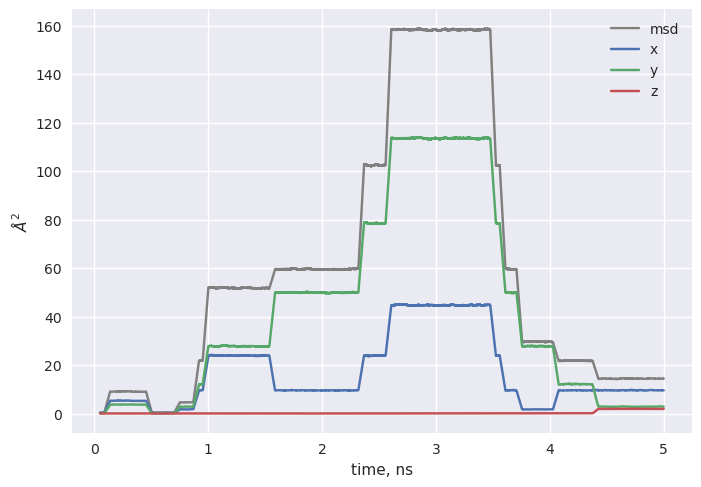

In [10]:


window_size = 5000  # Размер окна для скользящего среднего
sd_smoothed = datas[4][3].rolling(window=window_size).mean()

plt.plot(sd_smoothed['step'] / 1e6, sd_smoothed.drop('step', axis=1).sum(axis=1), label='msd', c='gray')
plt.plot(sd_smoothed['step'] / 1e6, sd_smoothed['x'], label='x')
plt.plot(sd_smoothed['step'] / 1e6, sd_smoothed['y'], label='y')
plt.plot(sd_smoothed['step'] / 1e6, sd_smoothed['z'], label='z')

plt.ylabel('$\\AA^2$')
plt.xlabel('time, ns')

plt.legend()
plt.show()

filtered_datas=[]
for j in range(len(T_array)):
    data_line = []
    for s in S:
        
        
        sd_smoothed = datas[s-1][j].rolling(window=window_size).mean()
        sd_smoothed['step'] = datas[s-1][j]['step']
        if not np.any(sd_smoothed['z'] > 1.4):
            data_line.append(sd_smoothed)
            
    filtered_datas.append(data_line)


In [11]:
for i in range(len(filtered_datas)):
    print(T_array[i], len(filtered_datas[i]))
    


523 10
548 9
573 10
623 3
673 5
723 1


In [28]:
len(filtered_datas[3])

5

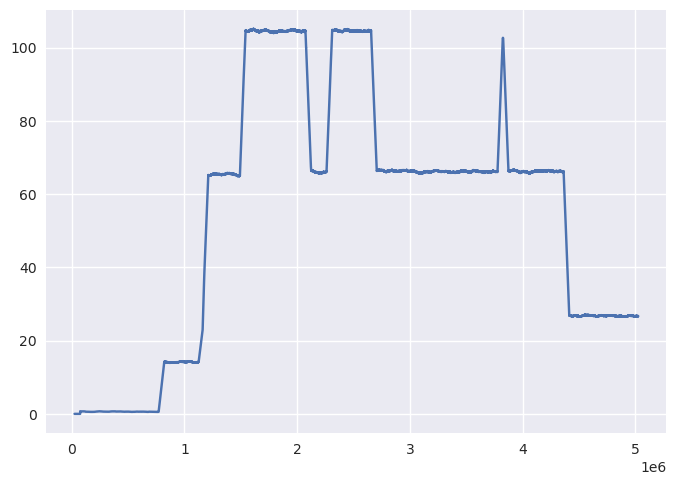

In [40]:
s = 0
t = 2
plt.plot(filtered_datas[t][s]['step'], filtered_datas[t][s].drop('step', axis=1).sum(axis=1))

In [12]:
threshold = 4
step_offset = 4000

def calculate_jump_frequency(filtered_data, threshold, step_offset):
    total_jumps = 0
    total_steps = 0
    
    for df in filtered_data:
        # Вычисляем суммарный квадрат смещения для каждого шага
        df['r2'] = df['x'] + df['y'] + df['z']
        
        # Инициализация указателя
        i = 0
        n = len(df)
        
        # Подсчет перескоков
        while i + step_offset < n:
            delta_r2 = df['r2'].iloc[i + step_offset] - df['r2'].iloc[i]
            
            # Если разница превышает порог, считаем это перескоком
            if abs(delta_r2) >= threshold:
                total_jumps += 1
                i += step_offset  # Сдвигаем указатель на step_offset шагов
            else:
                i += 20  # Сдвигаем указатель на 1 шаг
        
        total_steps += (df['step'].max() - df['step'].min())/ 1e6
    
    # Частота перескока (число перескоков на шаг)
    if total_steps > 0:
        jump_frequency = total_jumps / total_steps
    else:
        jump_frequency = 0.0
    
    return jump_frequency

# Расчет частоты перескока для каждой температуры
jump_frequencies = []
for i, temp in enumerate(T_array):
    filtered_data = filtered_datas[i]
    nu = calculate_jump_frequency(filtered_data, threshold, step_offset)
    jump_frequencies.append(nu)
    print(f"Температура: {temp} K, Частота: {nu:.3f} 1/ns,", f"Число прыжков: {nu * 5 * len(filtered_data):.1f}, Число конфигураций: {len(filtered_data)}")


Температура: 523 K, Частота: 0.340 1/ns, Число прыжков: 17.0, Число конфигураций: 10
Температура: 548 K, Частота: 0.333 1/ns, Число прыжков: 15.0, Число конфигураций: 9
Температура: 573 K, Частота: 0.660 1/ns, Число прыжков: 33.0, Число конфигураций: 10
Температура: 623 K, Частота: 1.333 1/ns, Число прыжков: 20.0, Число конфигураций: 3
Температура: 673 K, Частота: 0.640 1/ns, Число прыжков: 16.0, Число конфигураций: 5
Температура: 723 K, Частота: 2.000 1/ns, Число прыжков: 10.0, Число конфигураций: 1


In [103]:
np.delete(T_array, 2)

array([523, 573, 673, 723])

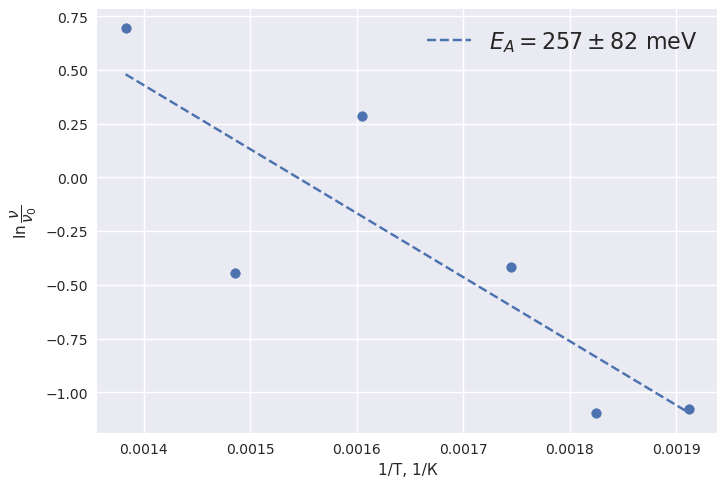

In [14]:
from scipy.constants import k, e, N_A

X = 1 / np.array(T_array)
Y = np.log(jump_frequencies)

res = linregress(X, Y)
grid = np.linspace(X.min(), X.max(), 101)

E_activation = - ufloat(res.slope, res.stderr) * k / e * 1e3
plt.scatter(1 / np.array(T_array), np.log(jump_frequencies))
plt.plot(grid, grid * res.slope + res.intercept, label=f'$E_A = {E_activation.nominal_value:.0f} \\pm {E_activation.std_dev:.0f}$ meV', linestyle='--')
plt.ylabel('$\\ln \\dfrac{\\nu}{\\nu_0}$')
plt.xlabel('1/T, 1/К')
plt.legend(fontsize=16)
plt.show()

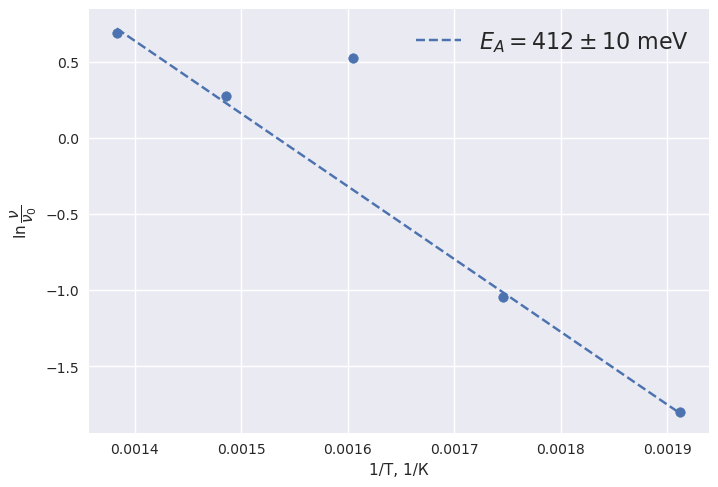

In [113]:
from scipy.constants import k, e, N_A

X = np.delete(1 / np.array(T_array), 2)
Y = np.delete(np.log(jump_frequencies), 2)

res = linregress(X, Y)
grid = np.linspace(X.min(), X.max(), 101)

E_activation = - ufloat(res.slope, res.stderr) * k / e * 1e3
plt.scatter(1 / np.array(T_array), np.log(jump_frequencies))
plt.plot(grid, grid * res.slope + res.intercept, label=f'$E_A = {E_activation.nominal_value:.0f} \\pm {E_activation.std_dev:.0f}$ meV', linestyle='--')
plt.ylabel('$\\ln \\dfrac{\\nu}{\\nu_0}$')
plt.xlabel('1/T, 1/К')
plt.legend(fontsize=16)
plt.show()